In [1]:
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
from sklearn.metrics import confusion_matrix, det_curve
from sklearn.metrics import f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from collections import defaultdict
import numpy as np

import sys
import time
repo_root = "../../"
sys.path.append(repo_root)
from models import CompositeClassifier
from utils.functions import fix_random_seed
fix_random_seed()

x_train = np.load("X-1647041985-early-fusion-vectors-train.arr")
y_train = np.load("y-1647041985-train.arr")

x_test = np.load("X-1647097165-early-fusion-vectors-test.arr")
y_test = np.load("y-1647097165-test.arr")

def fit(models, x_trains, y_train, save=False):
    for model in models:
        
        print(f"Fitting model: {model}", end=" | ")
        c1 = time.time()
        models[model].fit(x_trains[model], y_train)
        if save:
            models[model].save_late_fusion_model()
        print(f"Took: {time.time() - c1:.2f}s")

def evaluate(models, x_tests, y_test, ax=None, print_score=True):
    probs = {}
    for model in models:
        probs[model] = models[model].predict_proba(x_tests[model])[:,1]
        preds = np.where(probs[model] > 0.5, 1, 0)
        if print_score:
            print("\n", "="*6, f"{model}", "="*6)
            print(f"ROC AUC score: {roc_auc_score(y_test, probs[model])}")
            print(f"Classification report:")
            print(classification_report(y_test, preds, digits=4))

    model = "No Skill"
    most_common_label = np.argmax(np.bincount(y_test.astype(int)))
    probs[model] = np.array([most_common_label for _ in range(len(y_test))], dtype=int)
    
    if not ax:
        _, ax = plt.subplots(figsize=(14,6))
    
    for model in probs:
        fpr, tpr, _ = roc_curve(y_test, probs[model])
        # plot the roc curve for the model
        linestyle = "--" if model == "No Skill" else "solid"
        ax.plot(fpr, tpr, linestyle=linestyle, label=model)
        # axis labels
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    _ = ax.legend()
    return probs

/home/dmitrijs.trizna/.pyenv/versions/3.8-dev/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Different late fusion networks

In [2]:
models = {}
modules = ["malconv", "ember", "filepaths", "emulation"]

params = {
"malconv_model_path": 'modules/sota/malconv/parameters/malconv.checkpoint',
"ember_2019_model_path": 'modules/sota/ember/parameters/ember_model.txt',
"filepath_model_path": 'modules/filepath/pretrained/1646930331-model.torch',
"filepath_bytes": 'modules/filepath/pretrained/keep_bytes-ed64-pl150-kb150-1646917941.pickle',
"emulation_model_path": 'modules/emulation/pretrained/1646990611-model.torch',
"emulation_apicalls": 'modules/emulation/pretrained/api_calls_preserved-ed96-pl150-kb600-1646926097.pickle',
}

models["Logistic Regression"] = CompositeClassifier(modules=modules, late_fusion_model="LogisticRegression", **params, root=repo_root)
models["XGBClassifier"] = CompositeClassifier(modules=modules, late_fusion_model="XGBClassifier",**params, root=repo_root)
models["MultiLayerPerceptron15"] = CompositeClassifier(modules=modules, late_fusion_model="MultiLayerPerceptron",**params, root=repo_root, mlp_hidden_layer_sizes=(15,))
models["MultiLayerPerceptron50"] = CompositeClassifier(modules=modules, late_fusion_model="MultiLayerPerceptron",**params, root=repo_root, mlp_hidden_layer_sizes=(50,))
models["MultiLayerPerceptron100"] = CompositeClassifier(modules=modules, late_fusion_model="MultiLayerPerceptron",**params, root=repo_root, mlp_hidden_layer_sizes=(100,))

x_trains = dict([(model, x_train) for model in models])
x_tests = dict([(model, x_test) for model in models])

In [3]:
fit(models, x_trains, y_train)

Fitting model: Logistic Regression | Took: 0.16s
Fitting model: XGBClassifier | Took: 7.38s
Fitting model: MultiLayerPerceptron15 | Took: 2.80s
Fitting model: MultiLayerPerceptron50 | Took: 7.64s
Fitting model: MultiLayerPerceptron100 | Took: 13.00s



 ====== Logistic Regression ======
ROC AUC score: 0.9987736442550271
Classification report:
              precision    recall  f1-score   support

         0.0     0.9718    0.9625    0.9671      4982
         1.0     0.9859    0.9895    0.9877     13190

    accuracy                         0.9821     18172
   macro avg     0.9789    0.9760    0.9774     18172
weighted avg     0.9820    0.9821    0.9820     18172


 ====== XGBClassifier ======
ROC AUC score: 0.9990002218753243
Classification report:
              precision    recall  f1-score   support

         0.0     0.9755    0.9659    0.9707      4982
         1.0     0.9872    0.9908    0.9890     13190

    accuracy                         0.9840     18172
   macro avg     0.9813    0.9784    0.9798     18172
weighted avg     0.9840    0.9840    0.9840     18172


 ====== MultiLayerPerceptron15 ======
ROC AUC score: 0.9987725637921993
Classification report:
              precision    recall  f1-score   support

         0.0   

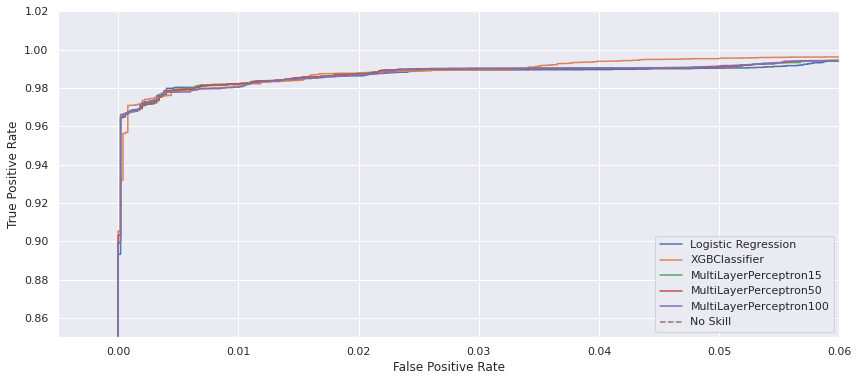

In [4]:
pp = evaluate(models, x_tests, y_test)
plt.xlim([-0.005, 0.06])
plt.ylim([0.85, 1.02])
plt.legend(loc="lower right")

## Different modules

In [5]:
modulelist = [["malconv"], ["ember"], ["filepaths"], ["emulation"], 
            ["malconv", "ember", "filepaths", "emulation"], 
            ["malconv", "ember", "emulation"]]
models = {}
x_trains = {}
x_tests = {}
for modules in modulelist:
    name = "_".join(modules)
    if len(modules) == 4:
        name = "All"
    if name == "malconv_ember_emulation":
        name = "PE modules (MalConv, Ember, emulation)"
    
    params = {
    "malconv_model_path": 'modules/sota/malconv/parameters/malconv.checkpoint',
    "ember_2019_model_path": 'modules/sota/ember/parameters/ember_model.txt',
    "filepath_model_path": 'modules/filepath/pretrained/1646930331-model.torch',
    "filepath_bytes": 'modules/filepath/pretrained/keep_bytes-ed64-pl150-kb150-1646917941.pickle',
    "emulation_model_path": 'modules/emulation/pretrained/1646990611-model.torch',
    "emulation_apicalls": 'modules/emulation/pretrained/api_calls_preserved-ed96-pl150-kb600-1646926097.pickle',
    }
    models[name] = CompositeClassifier(modules=modules, late_fusion_model="MultiLayerPerceptron", mlp_hidden_layer_sizes=(15,), **params, root=repo_root)
    x_trains[name] = models[name].get_modular_x(modules, x_train)
    x_tests[name] = models[name].get_modular_x(modules, x_test)

In [6]:
fit(models, x_trains, y_train)

Fitting model: malconv | Took: 2.66s
Fitting model: ember | Took: 5.46s
Fitting model: filepaths | Took: 2.77s
Fitting model: emulation | Took: 2.09s
Fitting model: All | Took: 2.81s
Fitting model: PE modules (MalConv, Ember, emulation) | Took: 2.36s


In [7]:
def get_threshold_from_rate(thresholds, rate_array, rate):
    index = np.where(rate_array >= rate)[0][0]
    return thresholds[index]

def get_value_from_threshold(values, thresholds, threshold):
    thr_index = np.where(thresholds <= threshold)[0][0]
    return values[thr_index]

probs = {}
for model in models:
    probs[model] = models[model].predict_proba(x_tests[model])[:,1]

fprs = {}
fnrs = {}
tprs = {}
thresholds_roc = {}
thresholds_det = {}

for model in probs:
    fprs[model], tprs[model], thresholds_roc[model] = roc_curve(y_test, probs[model])
    _, fnrs[model], thresholds_det[model] = det_curve(y_test, probs[model])

In [8]:
fixed_fpr_rates = defaultdict(list)
for fpr_rate in list(np.arange(0.00025, 0.0031, 0.00025)):
    print("===" * 10)
    for model in models:
        threshold = get_threshold_from_rate(thresholds_roc[model], fprs[model], fpr_rate)
        tpr_rate = get_value_from_threshold(tprs[model], thresholds_roc[model], threshold)
        fnr_rate = get_value_from_threshold(fnrs[model], thresholds_det[model][::-1], threshold)
        fixed_fpr_rates[model].append([fpr_rate, tpr_rate, fnr_rate, threshold]) 
        print(f"FPR: {fpr_rate*100:>5.3f}% | TPR: {tpr_rate*100:>5.2f}% | FNR: {fnr_rate*100:>5.2f}% | Thr.: {threshold:>5.4f} | {model}")

FPR: 0.025% | TPR:  0.12% | FNR:  0.02% | Thr.: 0.8334 | malconv
FPR: 0.025% | TPR: 14.14% | FNR:  0.02% | Thr.: 0.9951 | ember
FPR: 0.025% | TPR:  4.23% | FNR:  0.02% | Thr.: 0.9988 | filepaths
FPR: 0.025% | TPR: 27.76% | FNR:  0.06% | Thr.: 0.9956 | emulation
FPR: 0.025% | TPR: 96.46% | FNR:  0.02% | Thr.: 0.9990 | All
FPR: 0.025% | TPR: 65.58% | FNR:  0.01% | Thr.: 0.9990 | PE modules (MalConv, Ember, emulation)
FPR: 0.050% | TPR:  0.36% | FNR:  0.17% | Thr.: 0.8334 | malconv
FPR: 0.050% | TPR: 18.04% | FNR:  0.22% | Thr.: 0.9951 | ember
FPR: 0.050% | TPR: 15.66% | FNR:  0.06% | Thr.: 0.9988 | filepaths
FPR: 0.050% | TPR: 37.20% | FNR:  0.06% | Thr.: 0.9955 | emulation
FPR: 0.050% | TPR: 96.65% | FNR:  0.02% | Thr.: 0.9988 | All
FPR: 0.050% | TPR: 66.69% | FNR:  0.01% | Thr.: 0.9990 | PE modules (MalConv, Ember, emulation)
FPR: 0.075% | TPR:  0.41% | FNR:  0.22% | Thr.: 0.8334 | malconv
FPR: 0.075% | TPR: 18.34% | FNR:  0.23% | Thr.: 0.9951 | ember
FPR: 0.075% | TPR: 23.32% | FNR:  

In [9]:
fixed_fnr_rates = defaultdict(list)
for fnr_rate in [0.0005, 0.001] + list(np.arange(0.0025, 0.02, 0.0025)):
    print("===" * 10)
    for model in models:
        threshold = get_threshold_from_rate(thresholds_det[model], fnrs[model], fnr_rate)
        tpr_rate = get_value_from_threshold(tprs[model], thresholds_roc[model], threshold)
        fpr_rate = get_value_from_threshold(fprs[model], thresholds_roc[model], threshold)
        fixed_fnr_rates[model].append([fpr_rate, tpr_rate, fnr_rate, threshold])
        print(f"FPR: {fpr_rate*100:>5.2f}% | TPR: {tpr_rate*100:>5.2f}% | FNR: {fnr_rate*100:>5.2f}% | Thr.: {threshold:>5.4f} | {model}")

FPR: 99.82% | TPR: 99.98% | FNR:  0.05% | Thr.: 0.4425 | malconv
FPR: 70.19% | TPR: 99.79% | FNR:  0.05% | Thr.: 0.0963 | ember
FPR: 90.45% | TPR: 99.95% | FNR:  0.05% | Thr.: 0.0003 | filepaths
FPR: 54.34% | TPR: 99.95% | FNR:  0.05% | Thr.: 0.0033 | emulation
FPR: 26.56% | TPR: 99.95% | FNR:  0.05% | Thr.: 0.0001 | All
FPR: 59.71% | TPR: 99.95% | FNR:  0.05% | Thr.: 0.0013 | PE modules (MalConv, Ember, emulation)
FPR: 99.70% | TPR: 99.89% | FNR:  0.10% | Thr.: 0.4431 | malconv
FPR: 70.19% | TPR: 99.79% | FNR:  0.10% | Thr.: 0.0963 | ember
FPR: 73.67% | TPR: 99.89% | FNR:  0.10% | Thr.: 0.0003 | filepaths
FPR: 33.26% | TPR: 99.89% | FNR:  0.10% | Thr.: 0.0035 | emulation
FPR: 14.67% | TPR: 99.89% | FNR:  0.10% | Thr.: 0.0006 | All
FPR: 20.31% | TPR: 99.89% | FNR:  0.10% | Thr.: 0.0025 | PE modules (MalConv, Ember, emulation)
FPR: 99.60% | TPR: 99.75% | FNR:  0.25% | Thr.: 0.4443 | malconv
FPR: 64.91% | TPR: 99.75% | FNR:  0.25% | Thr.: 0.0964 | ember
FPR: 58.51% | TPR: 99.75% | FNR:  


 ====== malconv ======
ROC AUC score: 0.6703612306806399
Classification report:
              precision    recall  f1-score   support

         0.0     0.5306    0.2868    0.3724      4982
         1.0     0.7705    0.9042    0.8320     13190

    accuracy                         0.7349     18172
   macro avg     0.6505    0.5955    0.6022     18172
weighted avg     0.7047    0.7349    0.7060     18172


 ====== ember ======
ROC AUC score: 0.9860326135421863
Classification report:
              precision    recall  f1-score   support

         0.0     0.8914    0.9785    0.9329      4982
         1.0     0.9916    0.9550    0.9729     13190

    accuracy                         0.9614     18172
   macro avg     0.9415    0.9667    0.9529     18172
weighted avg     0.9641    0.9614    0.9620     18172


 ====== filepaths ======
ROC AUC score: 0.9885937365417702
Classification report:
              precision    recall  f1-score   support

         0.0     0.9514    0.9279    0.9395     

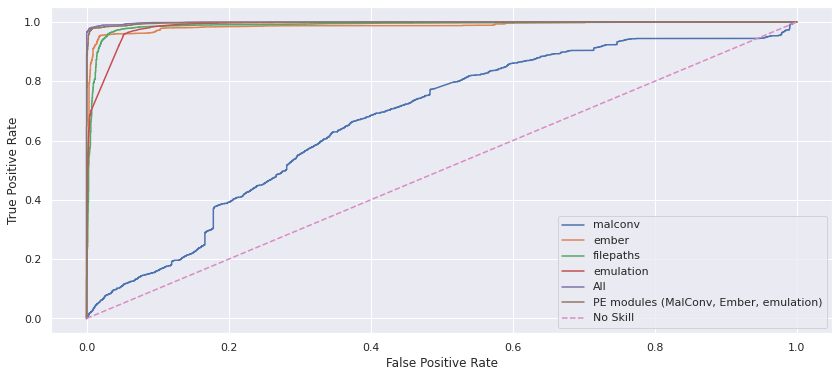

In [10]:
probs = evaluate(models, x_tests, y_test)

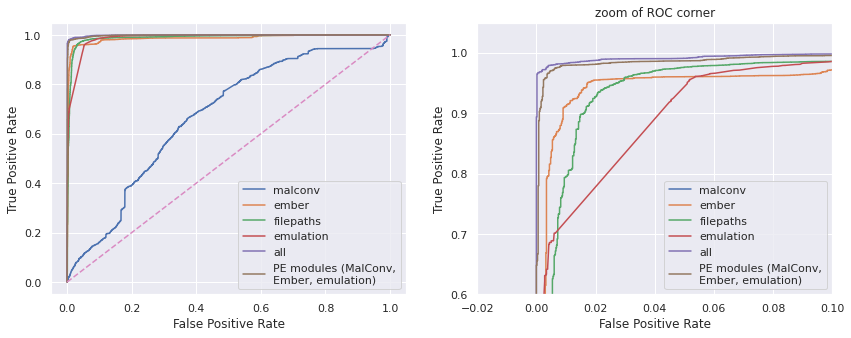

In [38]:
legend = ['malconv', 'ember', 'filepaths', 'emulation', 'all', 'PE modules (MalConv,\nEmber, emulation)']
fig, ax = plt.subplots(1,2, figsize=(14,5))
evaluate(models, x_tests, y_test, ax=ax[0], print_score=False)
probs = evaluate(models, x_tests, y_test, ax=ax[1], print_score=False)
ax[1].set_ylim([0.6, 1.05])
ax[1].set_xlim([-0.02, 0.1])
ax[1].set_title("zoom of ROC corner")
ax[1].legend(legend)
_ = ax[0].legend(legend)

In [12]:
def draw_confusion_matrix(y_true, y_pred, counts=False, figsize=(6,6)):
    cf_matrix = confusion_matrix(y_true, y_pred)

    group_counts = [f"{value:0.0f}" for value in cf_matrix.flatten()]
    group_percentages = [f"{value:.2%}" for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    groups = ["True Negative","False Positive","False Negative","True Positive"]

    if counts:
        labels = [f"{y}\n{x}\n{z}" for x,y,z in zip(group_percentages, groups, group_counts)]
    else:
        labels = [f"{y}\n{x}" for x,y in zip(group_percentages, groups)]
    labels = np.asarray(labels).reshape(2,2)

    f, ax = plt.subplots(1,1, figsize=figsize)
    ax = sns.heatmap(cf_matrix, annot=labels, ax=ax,
                fmt='', cbar=False, cmap='Blues',
                xticklabels=["benign", "malicious"],
                yticklabels=["benign", "malicious"])
    ax.set_ylabel("Ground truth label")
    ax.set_xlabel("Prediction")

def print_scores(y_true, y_pred):
    print("F1: ",f1_score(y_true, y_pred))
    print("Recall: ", recall_score(y_true, y_pred))
    print("Precision: ", precision_score(y_true, y_pred))
    print("Accuracy: ", (y_true == y_pred).mean() * 100)

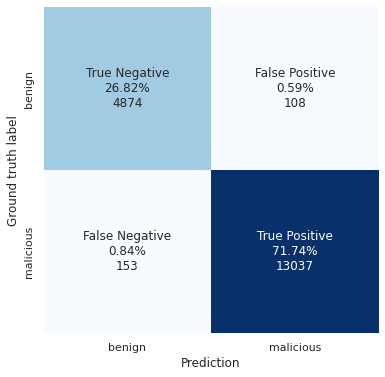

In [13]:
y_pred = (probs["All"] >= 0.6).astype(int)
draw_confusion_matrix(y_test, y_pred, counts=True)

In [14]:
print_scores(y_test, y_pred)

F1:  0.9900892348585534
Recall:  0.9884003032600455
Precision:  0.9917839482693039
Accuracy:  98.56372441118204


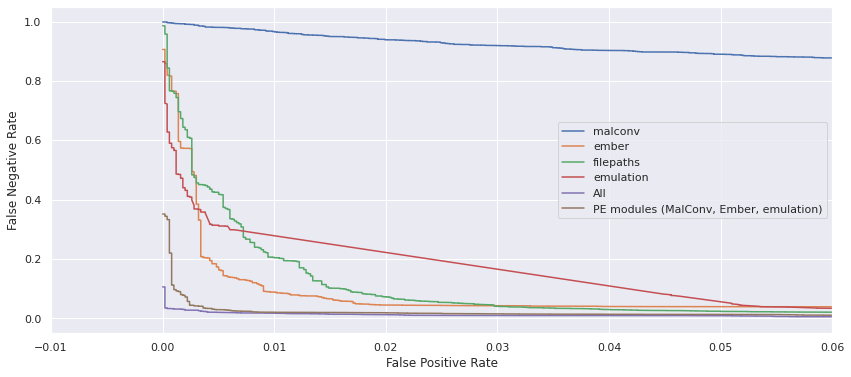

In [20]:
def plot_det_curve(models, x_tests, y_test, ax=None, print_score=True):
    probs = {}
    for model in models:
        probs[model] = models[model].predict_proba(x_tests[model])[:,1]
        preds = np.where(probs[model] > 0.5, 1, 0)
        if print_score:
            print("\n", "="*6, f"{model}", "="*6)
            print(f"ROC AUC score: {roc_auc_score(y_test, probs[model])}")
            print(f"Classification report:")
            print(classification_report(y_test, preds, digits=4))

    # model = "No Skill"
    # most_common_label = np.argmax(np.bincount(y_test.astype(int)))
    # probs[model] = np.array([most_common_label for _ in range(len(y_test))], dtype=int)
    
    if not ax:
        _, ax = plt.subplots(figsize=(14,6))
    
    for model in probs:
        fpr, tpr, _ = det_curve(y_test, probs[model])
        # plot the roc curve for the model
        linestyle = "--" if model == "No Skill" else "solid"
        ax.plot(fpr, tpr, linestyle=linestyle, label=model)
        # axis labels
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('False Negative Rate')
    _ = ax.legend()
    return probs

pp = plot_det_curve(models, x_tests, y_test, print_score=False)
_ = plt.xlim([-0.01, 0.06])

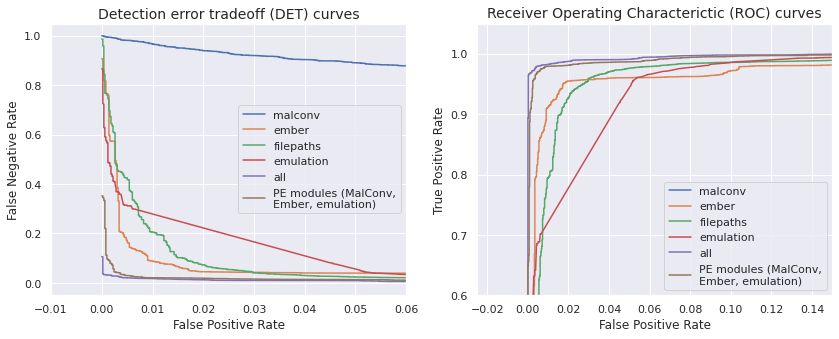

In [36]:
legend = ['malconv', 'ember', 'filepaths', 'emulation', 'all', 'PE modules (MalConv,\nEmber, emulation)']
fig, ax = plt.subplots(1,2, figsize=(14,5))
# evaluate(models, x_tests, y_test, ax=ax[0], print_score=False)
probs = evaluate(models, x_tests, y_test, ax=ax[1], print_score=False)
ax[1].set_ylim([0.6, 1.05])
ax[1].set_xlim([-0.025, 0.15])
ax[1].set_title("Receiver Operating Characterictic (ROC) curves", fontsize=14)
ax[1].legend(legend)

pp = plot_det_curve(models, x_tests, y_test, ax=ax[0], print_score=False)
ax[0].set_xlim([-0.01, 0.06])
ax[0].set_title("Detection error tradeoff (DET) curves", fontsize=14)
_ = ax[0].legend(legend)